# Solutions for Lab Sheet 3 (COM3502-4502-6502 Speech Processing)

This lab sheet (solution) is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") by clicking on the icon on the right, but this notebook is displayed best when opened locally using Jupyter Notebook (e.g. as part of the [Anaconda](https://www.anaconda.com/) distribution which is already installed on the lab computers). <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheet-Solutions/Lab-Sheet-3-Solution.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

<div class="alert alert-block alert-success">
<strong>Intended Learning Objectives (ILOs):</strong><br>
    
After completing this Jupyter Notenook you should
    
<ul>
<li>understand how a (speech) signal is split into blocks of data (frames) and analysis / transforms are conducted on these blocks
</li>
<li>calculate short-term energy and zero-crossing rates and visualise them to distinguish between voiced and unvoiced speech parts
</li>
<li>understand the basics of correlation and be able to implement a correlation estimator.
</li>
    
<li>understand basic use of <code>Python</code> <a href="https://docs.python.org/3/library/functions.html">command(s)</a>
    <ul>
        <li><a href="https://docs.python.org/3/library/functions.html#enumerate"><code>enumerate</code></a></li>
        <li><a href="https://docs.python.org/3/library/functions.html#func-range"><code>range</code></a></li>,
    </ul> 
</li>
<li>and functions from the <code>Python</code> libraries 
    <ul>
    <li><a href="https://numpy.org/doc/stable/index.html"><code>Numpy</code></a> command 
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.sign.html"><code>sign()</code></a>, 
    </li>
    </ul>
</li>
</ul>
</div>

In [1]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib inline
import matplotlib.pyplot as plt  # plotting
import seaborn as sns; sns.set() # styling (uncomment if you want)
import numpy as np               # math

## Loading a wave file (Task 1)

As done in previous lab sheets, we first download a wave file $s[k]$ using the `curl` command and the load it to a variable. Please note that the `curl` command below is slightly modified in comparison to previous lab sheets as it is using a variable name in curly brackets ({}). We can re-use the file name then later in the `sf.read()` command.

In [ ]:
# download speech and noise example files
s_file_name = 'speech_8kHz_murder.wav'
!curl https://staffwww.dcs.shef.ac.uk/people/n.ma/comx502/{s_file_name} -o {s_file_name} 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  328k  100  328k    0     0   850k      0 --:--:-- --:--:-- --:--:--  849k


In [3]:
import soundfile as sf
from IPython import display as ipd

# load speech wave into variable
s, fs = sf.read(s_file_name)

print('File "' + s_file_name + '" loaded. Its sampling rate is ' + str(fs) + ' Hz.')

# listen to the sound file (if you want)
ipd.Audio(s, rate=fs)

File "speech_8kHz_murder.wav" loaded. Its sampling rate is 8000 Hz.


## Block Processing (Task 2)

To illustrate block processing we first cut out a piece of $4096$ samples, starting at $10$ seconds, i.e. starting at sample no. $80,000$ for a sampling rate of $f_s = 8000 \,\mathrm{Hz}$ from $s[k]$ indicated in red slice in the upper panel and repeated in the lower panel in the figure below.

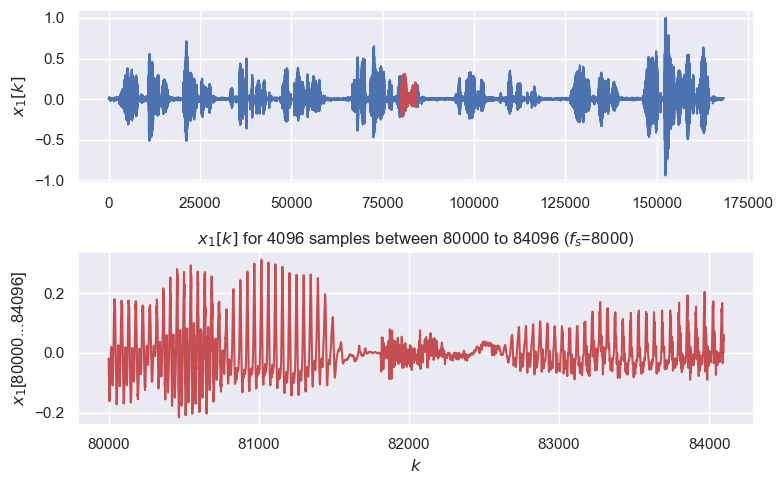

In [4]:
# lets cut out a piece of the data and cisualise it
start_sample = int(10*fs);                   # start at 10 sec
#print(start_sample)
no_of_samples = 4096;                        # no of samples we want to cut out    
end_sample   = start_sample + no_of_samples; # last sample to be cut out
sample_vec = np.linspace(start_sample, end_sample, no_of_samples)
x1=s[start_sample:end_sample];

plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.plot(np.arange(0,len(s)),s)
plt.ylabel('$x_1[k]$')
plt.plot(sample_vec,x1,'r')
plt.subplot(2,1,2)
plt.plot(sample_vec,x1,'r')
plt.xlabel('$k$')
plt.ylabel('$x_1$[' + str(start_sample) + '...' + str(end_sample) + ']')
plt.title('$x_1[k]$ for ' + str(len(x1)) + ' samples between ' 
          + str(start_sample) + ' to ' + str(end_sample) + 
          ' ($f_s$=' + str(fs) +')')
plt.tight_layout() # this allowes for some space for the title text.

In [5]:
# listen to the short cut-out
ipd.Audio(x1, rate=fs)

As commonly done for speech processing algorithms, a block processing (sliding window approach) is followed.

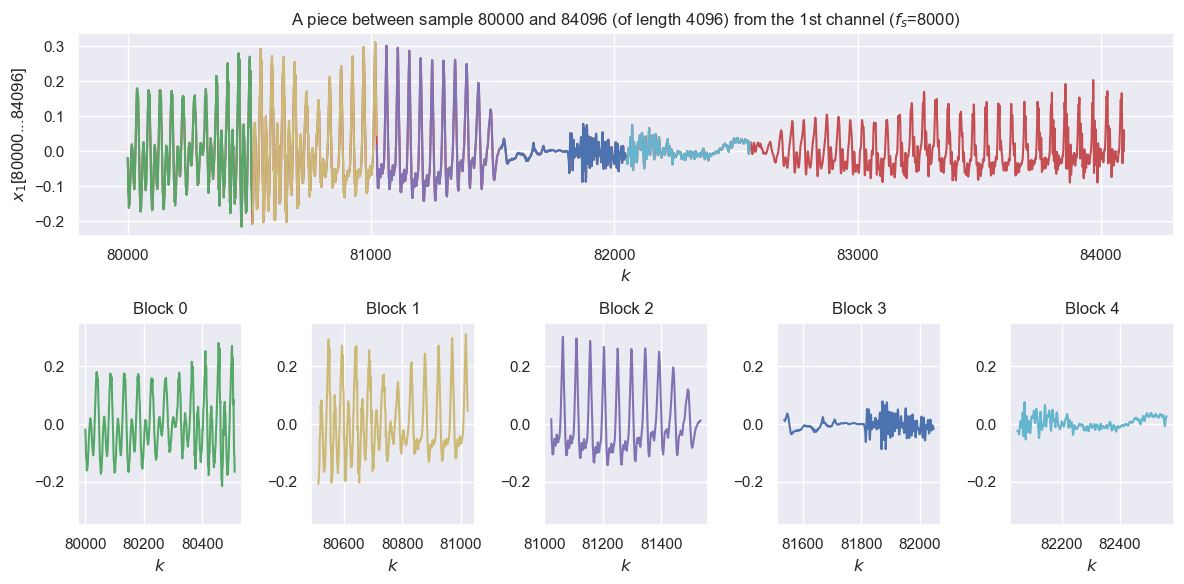

In [6]:
# lets cut out a piece of the data
Lw   = 512                    # frame length
Lov  = 1                      # frame overlap factor 
Lhop = int(np.round(Lw/Lov)); # frame hop size

# creating grid of axes for subplots
plt.figure(figsize=(12, 6))
ax1 = plt.subplot2grid(shape=(2, 5), loc=(0, 0), colspan=5)
ax2 = plt.subplot2grid(shape=(2, 5), loc=(1, 0), colspan=1)
ax3 = plt.subplot2grid(shape=(2, 5), loc=(1, 1), colspan=1)
ax4 = plt.subplot2grid(shape=(2, 5), loc=(1, 2), colspan=1)
ax5 = plt.subplot2grid(shape=(2, 5), loc=(1, 3), colspan=1)
ax6 = plt.subplot2grid(shape=(2, 5), loc=(1, 4), colspan=1)
ax_blocks = [ax2, ax3, ax4, ax5, ax6]

# plot signal part in upper panel (axis ax1)
ax1.plot(sample_vec,x1,'r') #
ax1.set_xlabel('$k$')
ax1.set_ylabel('$x_1$[' + str(start_sample) + '...' + str(end_sample) + ']');
ax1.set_title('A piece between sample ' + str(start_sample) + 
          ' and ' + str(end_sample) + ' (of length ' + str(len(x1)) + 
          ') from the 1st channel ($f_s$=' + str(fs) +')')
          
# plot single blocks in lower panels 
clrs = ['g','y','m','b','c','k']; # define a vector of colours
for ii,k in enumerate(range(start_sample,start_sample+5*Lhop,Lhop)):
    block_k_vec = np.arange(k,k+Lw)
    block_sig_vec = x1[ii*Lhop:ii*Lhop+Lw]
    ax1.plot(block_k_vec,block_sig_vec,clrs[ii])

    ax_blocks[ii].plot(block_k_vec,block_sig_vec,clrs[ii])
    ax_blocks[ii].set_xlabel('$k$')
    ax_blocks[ii].set_ylim(-0.35, 0.35)
    ax_blocks[ii].set_title('Block ' + str(ii))

# automatically adjust padding horizontally 
# as well as vertically.
plt.tight_layout()

The figure above shows some of the frames / blocks of length $L_{\mathrm{Bl}}=512$ in the lower panels. Given the sampling frequency of $f_s=8000 \,\mathrm{Hz}$ we can calculate that a block length is

$L_{\mathrm{Bl}} = 512$ samples $/$ $8000 \,\mathrm{Hz} = 64 \,\mathrm{ms}$

Since we know that a speech signal is (short-term) stationary in a time window of $\approx 10 .. 30 \,\mathrm{ms}$ we can conclude that it probably would be a good idea to use shorter frames, i.e. a smaller $L_{\mathrm{Bl}}$. This can also be seen for the last two frames (blue colours) where the change in statistics can be even observed from the time-domain signal (e.g. the first half of Block 3 look considerably different than the second half).

## Voiced/Unvoiced Analysis

The following code downloads two wave files `https://staffwww.dcs.shef.ac.uk/people/n.ma/comx502/voiced_unvoiced_e.wav` and `https://staffwww.dcs.shef.ac.uk/people/n.ma/comx502/voiced_unvoiced_z.wav` and stores them in variables `e` and `z`. Since these have a different sampling frequency $f_s$ we store their sampling frequencies in seperate variables `fs_e` and `fs_z`.

In [ ]:
file_name = 'voiced_unvoiced_e.wav'
#file_name = 'word_fish.wav'         # another one to play around with (if you like)

# download speech and noise example files
!curl https://staffwww.dcs.shef.ac.uk/people/n.ma/comx502/{file_name} -o {file_name} 
# load speech wave into variable
e, fs_e = sf.read(file_name)

print('File "' + file_name + '" loaded. It has a sampling rate of f_s = ' + str(fs_e) + ' Hz.')

file_name = 'voiced_unvoiced_z.wav'
#file_name = 'word_speech.wav'     # another one to play around with (if you like)

# download speech and noise example files
!curl https://staffwww.dcs.shef.ac.uk/people/n.ma/comx502/{file_name} -o {file_name} 
# load speech wave into variable
z, fs_z = sf.read(file_name)

print('File "' + file_name + '" loaded. It has a sampling rate of f_s = ' + str(fs_z) + ' Hz.')

File "voiced_unvoiced_e.wav" loaded. It has a sampling rate of f_s = 44100 Hz.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 77100  100 77100    0     0  2906k      0 --:--:-- --:--:-- --:--:-- 3011k


File "voiced_unvoiced_z.wav" loaded. It has a sampling rate of f_s = 44100 Hz.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 65378  100 65378    0     0  2435k      0 --:--:-- --:--:-- --:--:-- 2553k


In [8]:
# listen to the sound file (if you want)
ipd.Audio(e, rate=fs_e)

In [9]:
# listen to the sound file (if you want)
ipd.Audio(z, rate=fs_z)

### Short-term energy


The short-term energy for each frame can be calculated by

\begin{equation}
E=\sum_{k=0}^{L_{\mathrm{Bl}}-1}s^2[k].
\end{equation}

Since we will re-use the code several times, we create a function.

In [10]:
def calc_STE(signal, sampsPerFrame):
    nFrames       = int(len(signal) / sampsPerFrame)        # number of non-overlapping 
    E = np.zeros(nFrames)
    for frame in range(nFrames):
        startIdx = frame * sampsPerFrame
        stopIdx = startIdx + sampsPerFrame
        E[frame]=np.sum(signal[startIdx:stopIdx] ** 2)
    return E

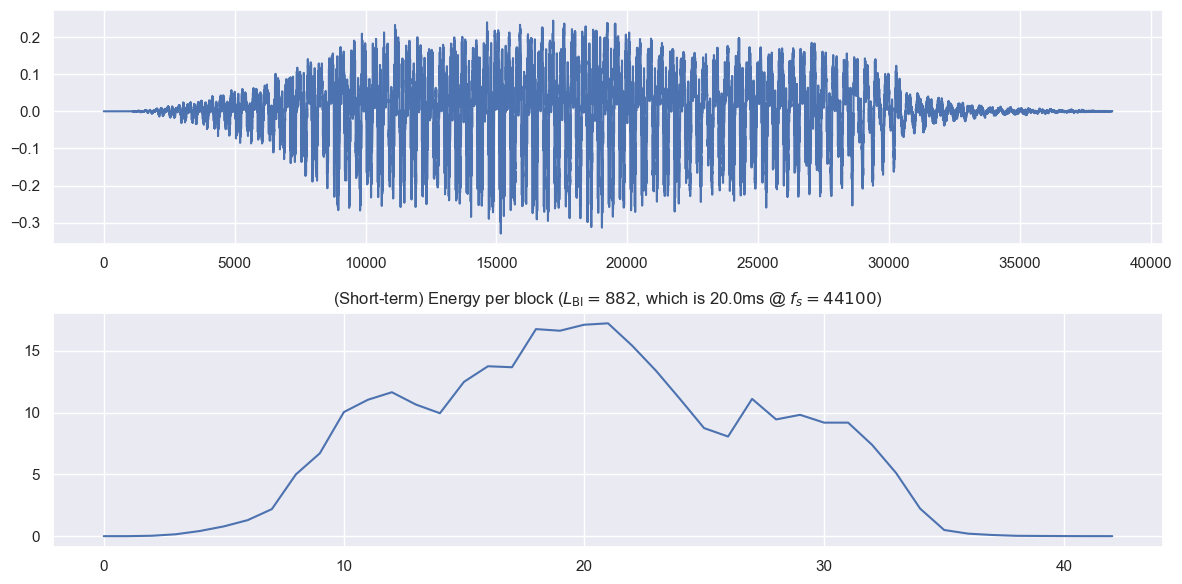

In [11]:
signal = e
sampsPerFrame = int(0.02 * fs_e) #20 ms

# creating grid for subplots
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(signal)
plt.subplot(2,1,2)
plt.plot(calc_STE(signal, sampsPerFrame))
plt.title('(Short-term) Energy per block ($L_{\mathrm{Bl}}=' + 
          str(sampsPerFrame) + '$, which is ' + 
          str(sampsPerFrame/fs_e*1000) + 'ms @ $f_s=' + str(fs_e) +'$)')
#plt.text(18,0.3, 'Short Term Energy is higher for voiced speech parts', style='italic',
#        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.tight_layout() # automatically adjust padding to make space for titles

ipd.Audio(e, rate=fs_e) # add possibility here to listen to the sound once again

The signal above is a voiced sound. We will compare the calculated (short-term) energy in the following with a less voiced sound.

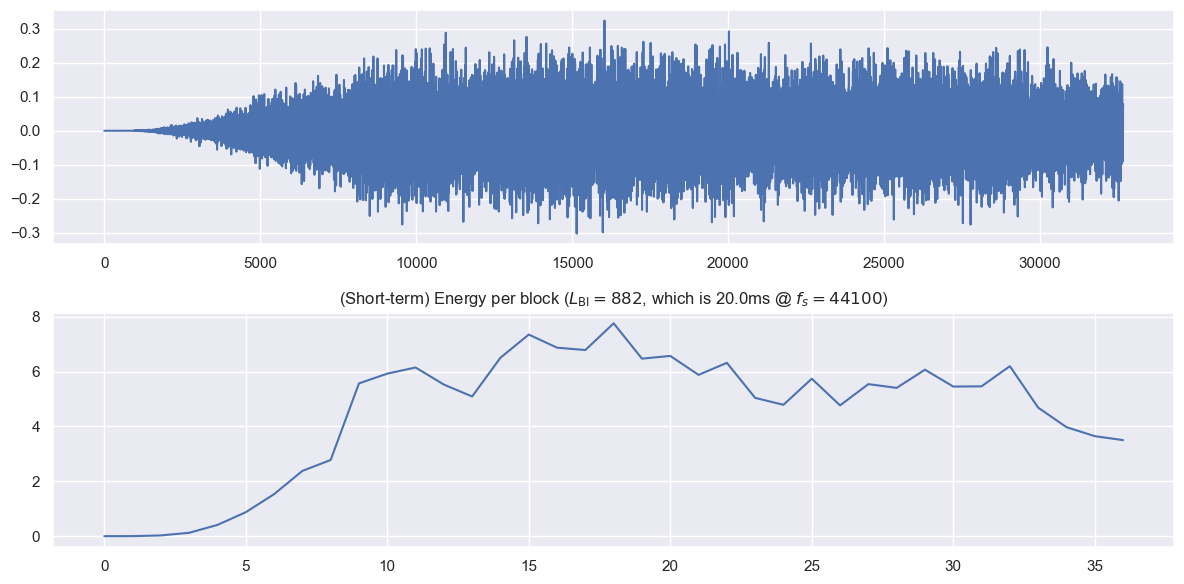

In [12]:
signal = z
sampsPerFrame = int(0.02 * fs_z) #20 ms

# plot
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(signal)
plt.subplot(2,1,2)
plt.plot(calc_STE(signal, sampsPerFrame))
plt.title('(Short-term) Energy per block ($L_{\mathrm{Bl}}=' + 
          str(sampsPerFrame) + '$, which is ' + 
          str(sampsPerFrame/fs_z*1000) + 'ms @ $f_s=' + str(fs_z) +'$)')
#plt.text(13,0.09, 'Short Term Energy is higher for voiced speech parts', style='italic',
#        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.tight_layout() # automatically adjust padding to make space for titles

ipd.Audio(z, rate=fs_z) # add possibility here to listen to the sound once again

The signal above is less voiced then the "e" sound we analysed before. We see that the calculated (short-term) energy is lower than for the previous example. 

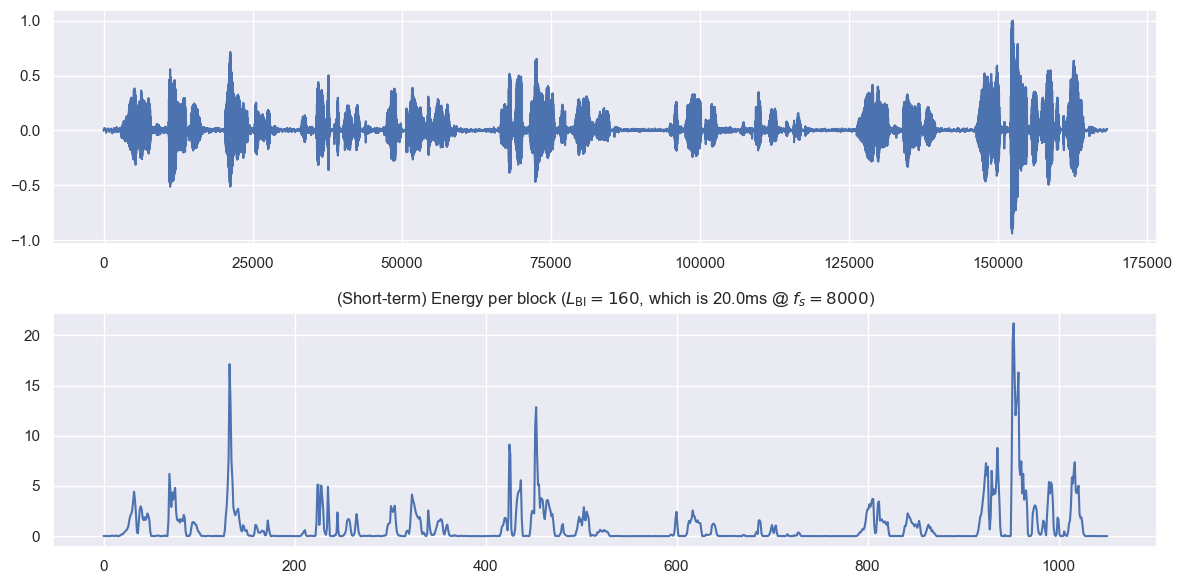

In [13]:
signal = s
sampsPerFrame = int(0.02 * fs) #20 ms

        
# plot
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(signal)
plt.subplot(2,1,2)
plt.plot(calc_STE(signal, sampsPerFrame))
plt.title('(Short-term) Energy per block ($L_{\mathrm{Bl}}=' + 
          str(sampsPerFrame) + '$, which is ' + 
          str(sampsPerFrame/fs*1000) + 'ms @ $f_s=' + str(fs) +'$)')
plt.tight_layout() # automatically adjust padding to make space for titles

### Zero-Crossing Rate

The zero crossing rate for a frame can be calculated by

\begin{equation}
\mathrm{ZCR}=\sum_{k=1}^{N−1} 0.5 |\mathrm{sign}(s[k])−\mathrm{sign}(s[k−1])|
\end{equation}

Like before, we put the code to actually calculate the ZCR into a function for easy re-use.

In [14]:
def calc_ZCR(signal, sampsPerFrame):
    nFrames = int(len(signal) / sampsPerFrame)        # number of non-overlapping 
    ZCR = np.zeros(nFrames)
    for frame in range(nFrames):
        startIdx = frame * sampsPerFrame
        stopIdx = startIdx + sampsPerFrame
        signalframe = signal[startIdx:stopIdx]
        for k in range(1, len(signalframe)):
            ZCR[frame] += 0.5 * abs(np.sign(signalframe[k]) - np.sign(signalframe[k - 1]))
    return ZCR

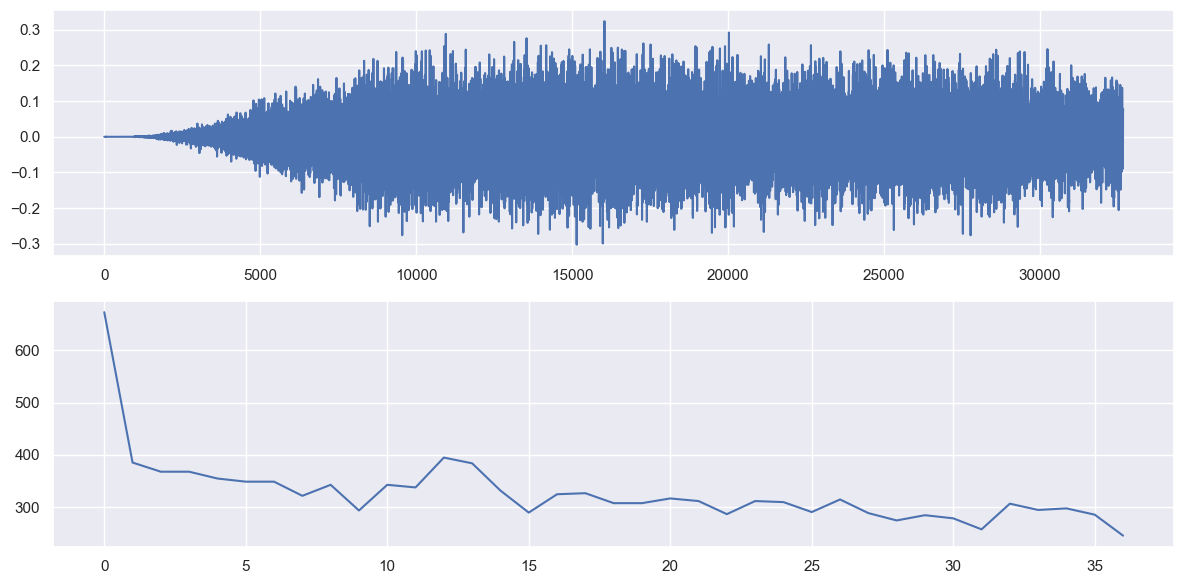

In [15]:
signal = z
sampsPerFrame = int(0.02 * fs_z) #20 ms
 
# creating grid for subplots
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(signal)
plt.subplot(2,1,2)
plt.plot(calc_ZCR(signal, sampsPerFrame))
#plt.text(25,30, 'Zero Crossing Rate is lower for voiced speech parts', style='italic',
#        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.tight_layout() # automatically adjust padding to make space for titles

ipd.Audio(z, rate=fs_z) # add possibility here to listen to the sound once again

The (relatively) voiceless sound above has a relatively high zero-crossing rate (higher than the voiceless sound analysed below).

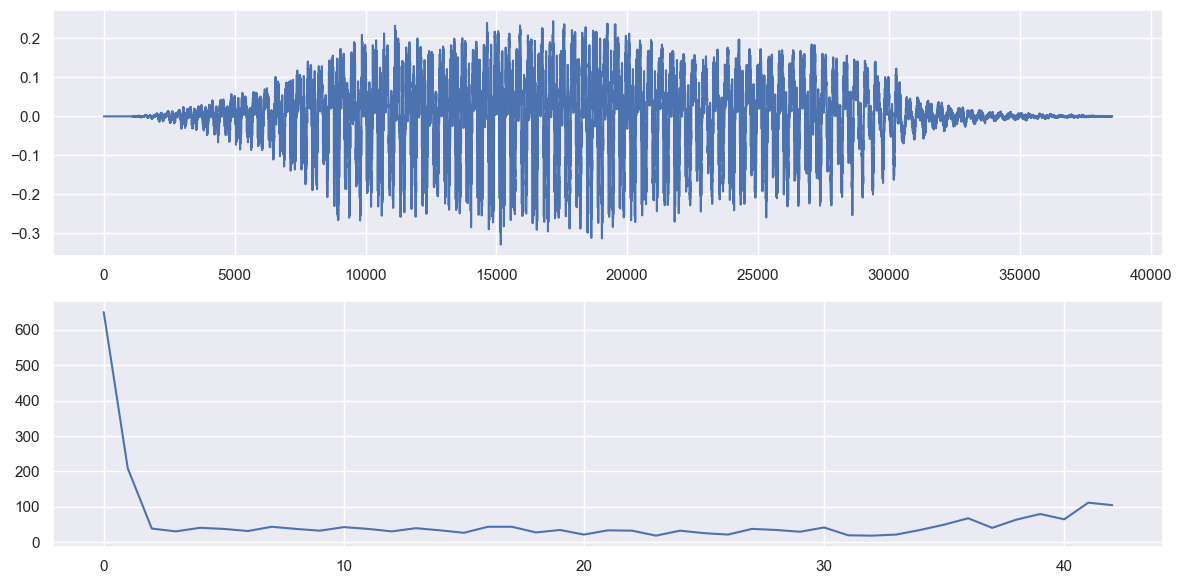

In [16]:
signal = e
sampsPerFrame = int(0.02 * fs_e) #20 ms

        
# creating grid for subplots
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(signal)
plt.subplot(2,1,2)
plt.plot(calc_ZCR(signal, sampsPerFrame))
#plt.text(22,30, 'Zero Crossing Rate is lower for voiced speech parts', style='italic',
#        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.tight_layout() # automatically adjust padding to make space for titles

ipd.Audio(e, rate=fs_e) # add possibility here to listen to the sound once again

Analysing the complete speech signal in the following shows us that threshold could be applied to distingush between voiced and unvoiced segments.

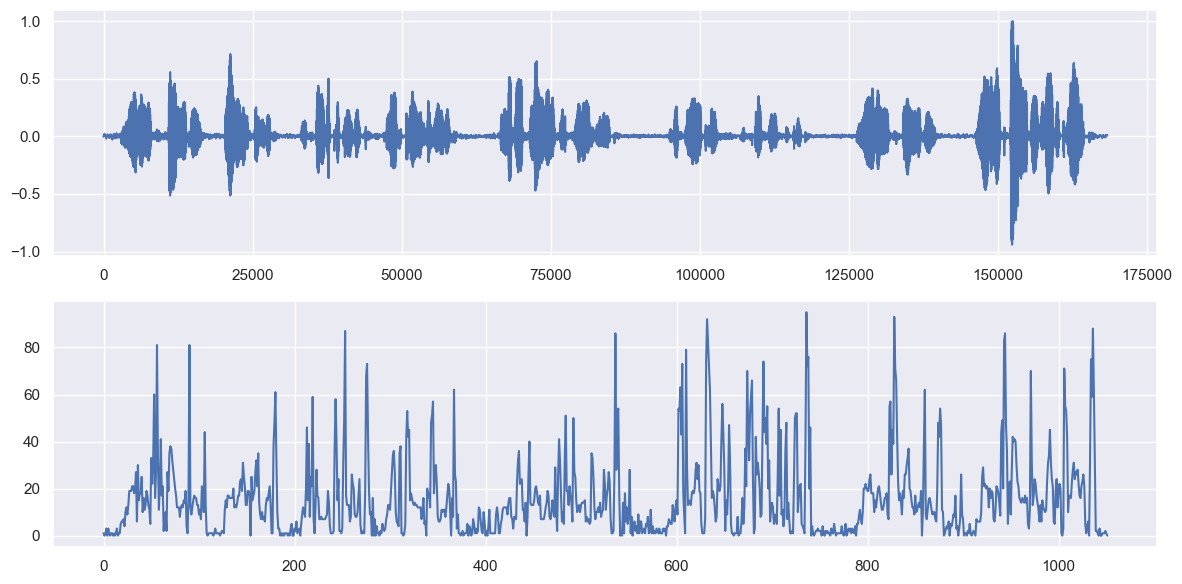

In [17]:
signal = s
sampsPerFrame = int(0.02 * fs) #20 ms

# creating grid for subplots
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(signal)
plt.subplot(2,1,2)
plt.plot(calc_ZCR(signal, sampsPerFrame))
plt.tight_layout() # automatically adjust padding to make space for titles

### Correlation of two sequences (Tasks 5 to 7)

Correlation describes a statistical relationship between data, in our case between speech signals which are viewed as (realisations of) processes. This means that correlation is a measurement of similarity:
Two signals which are highly correlated (i.e., which have a strong statistical relationship) are similar to each other.

The correlation between two signals $x[k]$ and $y[k]$ is defined as <sup>[[MW1]](https://mathworld.wolfram.com/StatisticalCorrelation.html)</sup>

\begin{equation}
r_{xy} = \frac{c_{xy}}{\sigma_x \sigma_y}
\end{equation}

where $\sigma_x$ and $\sigma_y$ are the [standard deviations](https://en.wikipedia.org/wiki/Standard_deviation "Definition of standard deviation on Wikipedia") of the signals and $c_{xy}$ is the [covariance](https://en.wikipedia.org/wiki/Covariance "Definition of covariance on Wikipedia") between the two signals which can be estimated from the signals (please note that the hat ($\hat{c}$) indicates that the quantity $c$ is estimated) by <sup>[[MW2]](https://mathworld.wolfram.com/Covariance.html)</sup>

\begin{equation}
\hat{c}_{xy} = \frac{1}{L}\sum_{k=1}^L (x[k]-\bar{x})(y[k]-\bar{y})
\end{equation}

with the respective [(sample) mean](https://en.wikipedia.org/wiki/Sample_mean_and_covariance) values

$$\bar{x} = \frac{1}{L}\sum_{i=1}^L x[i],$$
$$\bar{y} = \frac{1}{L}\sum_{i=1}^L y[i].$$

With estimates for the variances $\hat{\sigma}^2_x$ and $\hat{\sigma}^2_y$

$$\hat{\sigma}_x^2 = \frac{1}{L}\sum_{i=1}^L (x[i]-\bar{x})$$
$$\hat{\sigma}_y^2 = \frac{1}{L}\sum_{i=1}^L (y[i]-\bar{y})$$

we obtain

\begin{equation}
\hat{r}_{xy} = \frac{\sum_{k=1}^L (x[k]-\bar{x})(y[k]-\bar{y})}{L \cdot \hat{\sigma}_x \hat{\sigma}_y}.
\label{eq:defCorrelationEstWithMeanAndVariance}\tag{1}
\end{equation}

as an estimate of the correlation. If the means and standard deviations of the signals are $\bar{x}=\bar{y}=0$ and $\hat{\sigma}_x=\hat{\sigma}_y=1$, respectively, this simplifies to
\begin{equation}
\hat{r}_{xy} = \frac{1}{L}\sum_{k=1}^{L}x[k]y[k].
\label{eq:defCorrelationEst}\tag{2}
\end{equation}


In [18]:
def correlation(signal1, signal2):
    """Return the correlation value of two signals which are assumed to be normalized (mean 0, std 1)."""
    return np.mean(signal1 * signal2)

In [19]:
def normalize_and_correlate(signal1, signal2):
    """Return the correlation value of two signals after normalizing them."""
    return correlation(
        ((signal1 - np.mean(signal1)) / np.std(signal1)),
        ((signal2 - np.mean(signal2)) / np.std(signal2)),
    )

In [20]:
def plot_correlation(signal1, signal2, title=""):
    # Ensure that both signals have the same number of samples
    assert len(signal1) == len(signal2)
    
    # Ensure that the signals have both mean 0 and standard deviation 1
    signal1 = (signal1 - np.mean(signal1)) / np.std(signal1)
    signal2 = (signal2 - np.mean(signal2)) / np.std(signal2)
    
    multiplied_signals = signal1 * signal2
    correlation_value = correlation(signal1, signal2)

    y_max = max(np.max(np.abs(signal1)), np.max(np.abs(signal2)), np.max(np.abs(multiplied_signals)))
    
    #fig, axs = plt.subplots(3, figsize=(12, 6))
    fig = plt.figure(figsize=(12, 6), constrained_layout=True)
    fig.suptitle(title)

    # Create grid for the different plots
    gs = fig.add_gridspec(3, 10)

    axs = [fig.add_subplot(gs[0, :-1]), fig.add_subplot(gs[1, :-1]), 
           fig.add_subplot(gs[2, :-1]), fig.add_subplot(gs[:,-1])]
    
    axs[0].plot(np.arange(len(signal1)), signal1, marker="o", lw=0.1)
    axs[1].plot(np.arange(len(signal2)), signal2, marker="o", lw=0.1)
    axs[2].plot(np.arange(len(multiplied_signals)), multiplied_signals, marker="o", lw=0.1)
    axs[3].axhline(0, color="black", lw=0.5)
    axs[3].axhline(correlation_value, lw=5)

    axs[0].set_ylim(-y_max*1.1, y_max*1.1)
    axs[1].set_ylim(-y_max*1.1, y_max*1.1)
    axs[2].set_ylim(-y_max*1.1, y_max*1.1)
    axs[2].set_ylim(-np.max(np.abs(multiplied_signals)) * 1.1, np.max(np.abs(multiplied_signals)) * 1.1)
    axs[3].set_ylim(-1.01, 1.01)
    axs[3].set_xticks([])
    axs[0].get_xaxis().set_ticks([])
    axs[0].set_ylabel("$x[t]$")
    axs[1].set_ylabel("$y[t]$")
    axs[2].set_ylabel("$x[t]\cdot y[t]$")
    axs[1].get_xaxis().set_ticks([])
    axs[2].set_xlabel("time in samples")
    axs[0].title.set_text("The first signal $x[t]$")
    axs[1].title.set_text("The second signal $y[t]$")
    axs[2].title.set_text("Element-wise multiplication of both signals")
    axs[3].title.set_text("Correlation: {:.2f}".format(correlation_value))

#### Correlation of a (sine) signal with itself

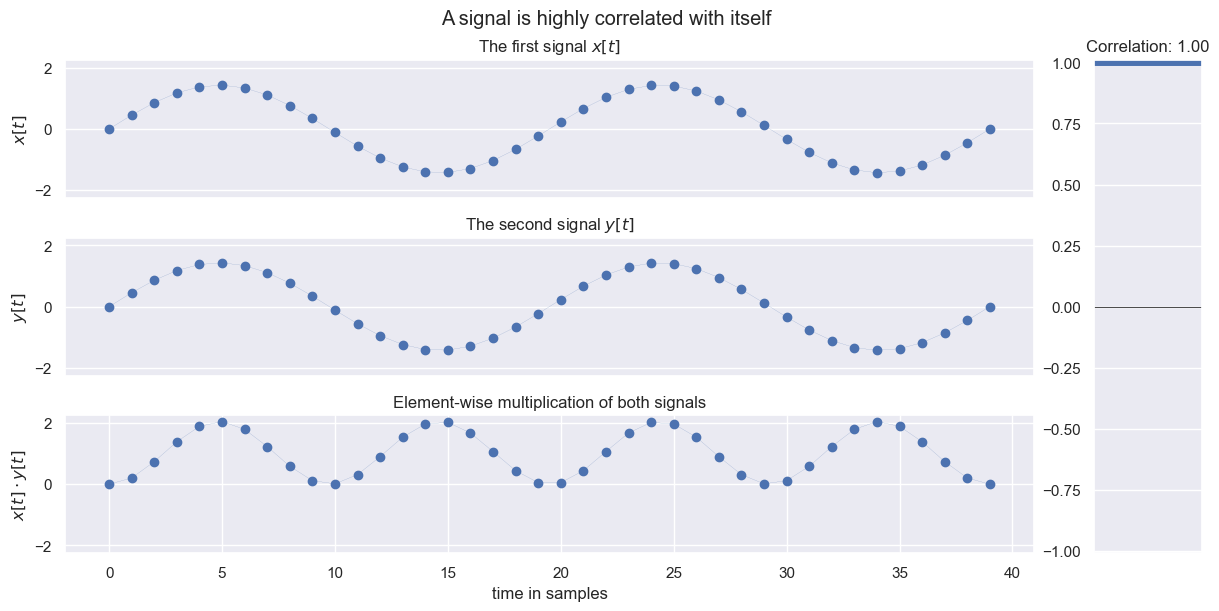

In [21]:
signal1 = np.sin(np.linspace(0, 4*np.pi, 40))
plot_correlation(signal1, signal1, "A signal is highly correlated with itself")

Here we see that the two signals are the same (we passed the same signal twice) and hence all element-wise products are positive. As a result the correlation value (which is displayed in the right panel as a blue bar) is high and positive.

#### Correlation of a sine wave with a sine wave shifted by $\pi$.

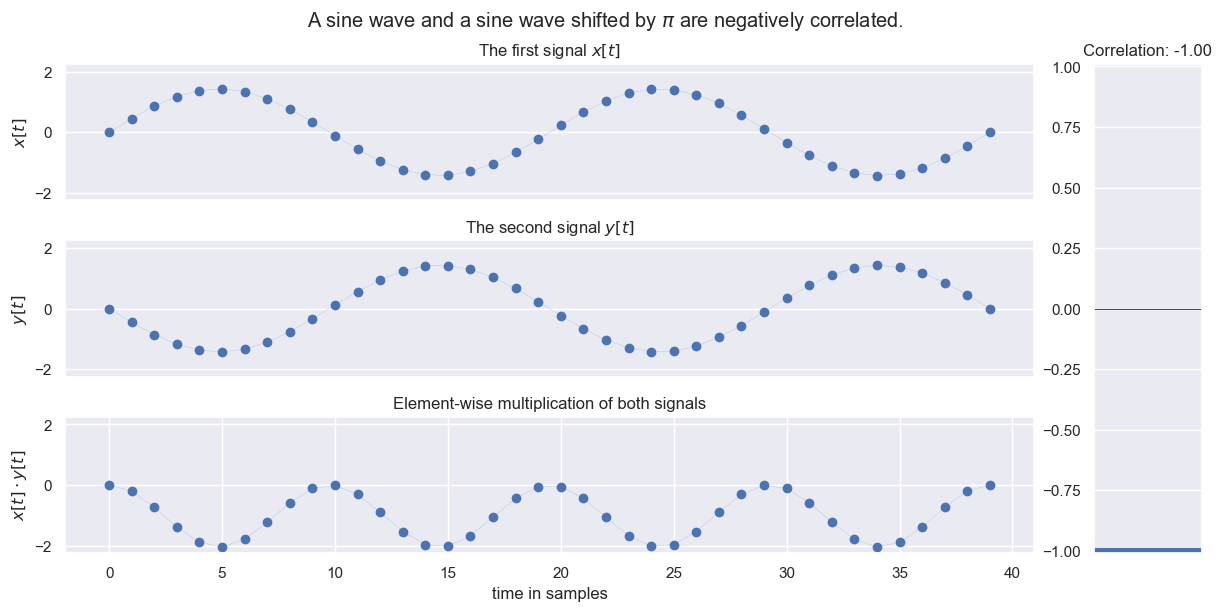

In [22]:
signal2 = np.sin(np.linspace(np.pi, 5*np.pi, 40))
plot_correlation(signal1, signal2, "A sine wave and a sine wave shifted by $\pi$ are negatively correlated.")

Here we see that the two signals are mirrored along the horizontal axis and hence all element-wise products are negative. As a result the correlation value is high but negative. Therefore it is also sometimes common to report the absolute value of the correlation.

#### Correlation of two (white) noise signals.

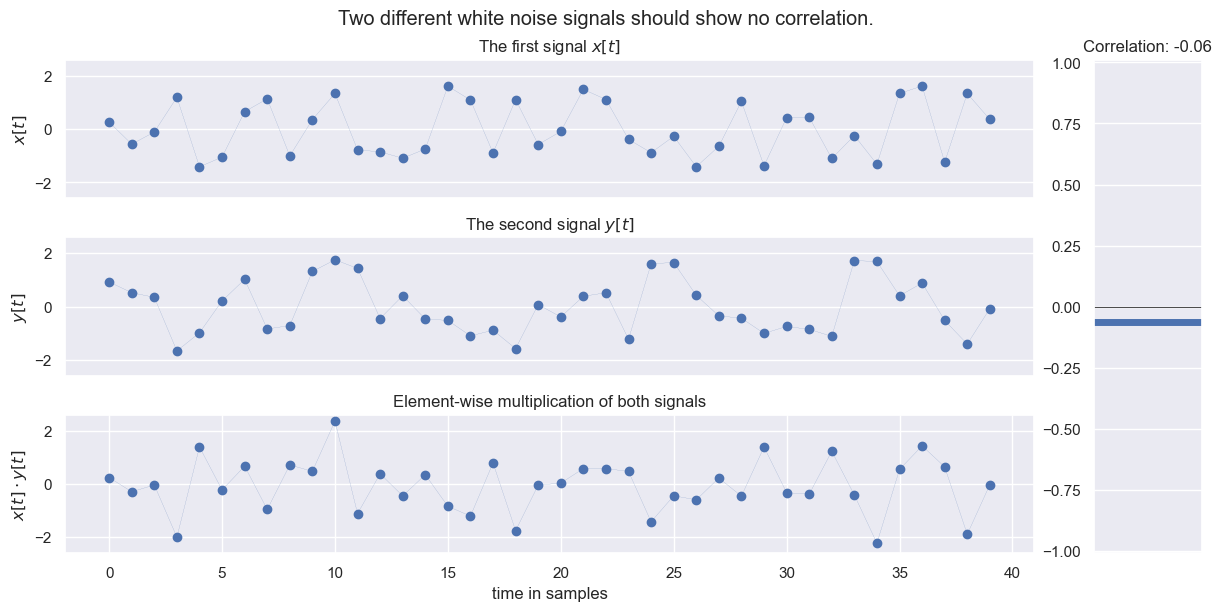

In [23]:
np.random.seed(100)
noise1 = np.random.uniform(-1, 1, size=40)
noise2 = np.random.uniform(-1, 1, size=40)
plot_correlation(noise1, noise2, "Two different white noise signals should show no correlation.")

As we can see in the previous (fixed) example, two noise signal do not have a high correlation. This results from their random nature.

*Note:* Since we always have to deal with variances of the signals, the measured correlation is seldom exactly $0$.

*Further note:* We will also use the correlation in a later lab-sheet to distinguis between voiced and unvoiced sound segments.

## Copyright

This notebook is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) to be used during the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield"). You may download, [clone](https://docs.github.com/en/repositories/creating-and-managing-repositories/cloning-a-repository) or [fork](https://docs.github.com/en/get-started/quickstart/fork-a-repo) it to your computer or private [GitHub](https://github.com/) account. 

### Contributors
[Stefan Goetze](http://www.stefan-goetze.de "Web page of Stefan Goetze"),
[Lena Strobl](https://github.com/sleyna/)